In [2]:
import os
import sys
import csv

sys.path.append('..')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import argparse as ap
import dan.data as ut
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from dan.embedding import EmbeddingTransformer
from dan.disguise import Disguise
from dan.discriminator import Discriminator
from dan.dan import DAN
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set(context='poster', style='whitegrid')

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

%config InlineBackend.figure_format = 'retina'

SyntaxError: invalid syntax (embedding.py, line 38)

In [8]:
DATA_DIR = '../data/processed/mm-cpc'
TEST_CSV = 'test.csv'
JSON_NAME = 'index-cardinality.json'
EXPERIMENT_DIR = '../models/dz-mm-cpc-embedded-imb/256-0.6-0.2-2L/'
DISCRMINATOR_ARCHITECTURE = [64, 32]
DISGUISE_ARCHITECTURE = [256, 256, 256, 256]
LEARNING_RATE = 1e-5  
LAMBDA = 0.5 
ETA = 0.2

In [71]:
X_test, y_test = ut.load_data(
os.path.join(DATA_DIR, TEST_CSV),
target='conversion_target')
print('Test data has shape: ', X_test.shape)
print('Test labels has shape: ', y_test.shape)
num_features = X_test.shape[1]

Test data has shape:  (284492, 143)
Test labels has shape:  (284492, 2)


In [72]:
# Create embedding map
json_path = os.path.join(DATA_DIR, JSON_NAME)
index_cardinality_map = ut.load_cardinality_map(json_path)

In [67]:
! ls -lhu ../models/dz-mm-cpc-embedded/256-100-0.2-2L/checkpoints/

total 284M
-rw-r--r-- 1 root root  93M Dec  5 02:52 -419356.data-00000-of-00001
-rw-r--r-- 1 root root 7.9K Dec  5 02:52 -419356.index
-rw-r--r-- 1 root root 1.4M Dec  5 02:52 -419356.meta
-rw-r--r-- 1 root root  93M Dec  5 03:45 -509218.data-00000-of-00001
-rw-r--r-- 1 root root 7.9K Dec  5 03:45 -509218.index
-rw-r--r-- 1 root root 1.4M Dec  5 03:45 -509218.meta
-rw-r--r-- 1 root root  93M Dec  5 04:21 -569126.data-00000-of-00001
-rw-r--r-- 1 root root 7.9K Dec  5 04:21 -569126.index
-rw-r--r-- 1 root root 1.4M Dec  5 04:21 -569126.meta
-rw-r--r-- 1 root root  147 Dec  5 04:21 checkpoint


In [73]:
checkpoint_dir = os.path.join(EXPERIMENT_DIR, 'checkpoints/')
log_dir = os.path.join(EXPERIMENT_DIR, 'logs/')

# Define DAN model
tf.reset_default_graph()
embedding_transformer = EmbeddingTransformer(index_cardinality_map)
num_features_embedding = embedding_transformer.calc_num_outputs(num_features)
print('Feature dimensionality in embedded space:', num_features_embedding)

if 'baseline' in EXPERIMENT_DIR:
    disguise = None
else:
    disguise = Disguise(num_features_embedding, DISGUISE_ARCHITECTURE)

discriminator = Discriminator(DISCRMINATOR_ARCHITECTURE)
dan = DAN(
    disguise, discriminator, checkpoint_dir, log_dir, embedding_transformer,
    num_inputs=num_features,
    learning_rate=LEARNING_RATE,
    lambd=LAMBDA,
    eta=ETA,
    early_stopping=4)

x_input_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, X_test.shape[1]))
x_embedded_tensor = embedding_transformer(x_input_placeholder)
x_embedded = dan.sess.run(x_embedded_tensor, feed_dict={x_input_placeholder: X_test})

pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_embedded)
print('Explained variances:', pca.explained_variance_ratio_)
x_pca_neg = x_pca[y_test[:,0].astype(bool),:]
x_pca_pos = x_pca[y_test[:,1].astype(bool),:]

if 'baseline' not in EXPERIMENT_DIR:
    x_disguised = dan.transform(X_test)
    x_pca_disguised = pca.transform(x_disguised)
else:
    x_pca_disguised = list()

pca_data = dict(pos=x_pca_pos, neg=x_pca_neg, dis=x_pca_disguised)

Feature dimensionality in embedded space: 340


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.
INFO:tensorflow:Summary name predictive entropy is illegal; using predictive_entropy instead.
INFO:tensorflow:Summary name discriminator loss is illegal; using discriminator_loss instead.
INFO:tensorflow:Summary name disguise quality is illegal; using disguise_quality instead.
INFO:tensorflow:Summary name disguise success rate is illegal; using disguise_success_rate instead.
INFO:tensorflow:Summary name disguise loss is illegal; using disguise_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name train auroc is illegal; using train_auroc instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
INFO:tensorflow:Summary name validation auroc is illegal; using validation_auroc instead.
INFO:tensorflow:Restoring parameters from ../models/dz-mm-cpc-embedded-imb/256-0.6-0.2-2L/checkpoints/

In [30]:
from mpl_toolkits.mplot3d import Axes3D

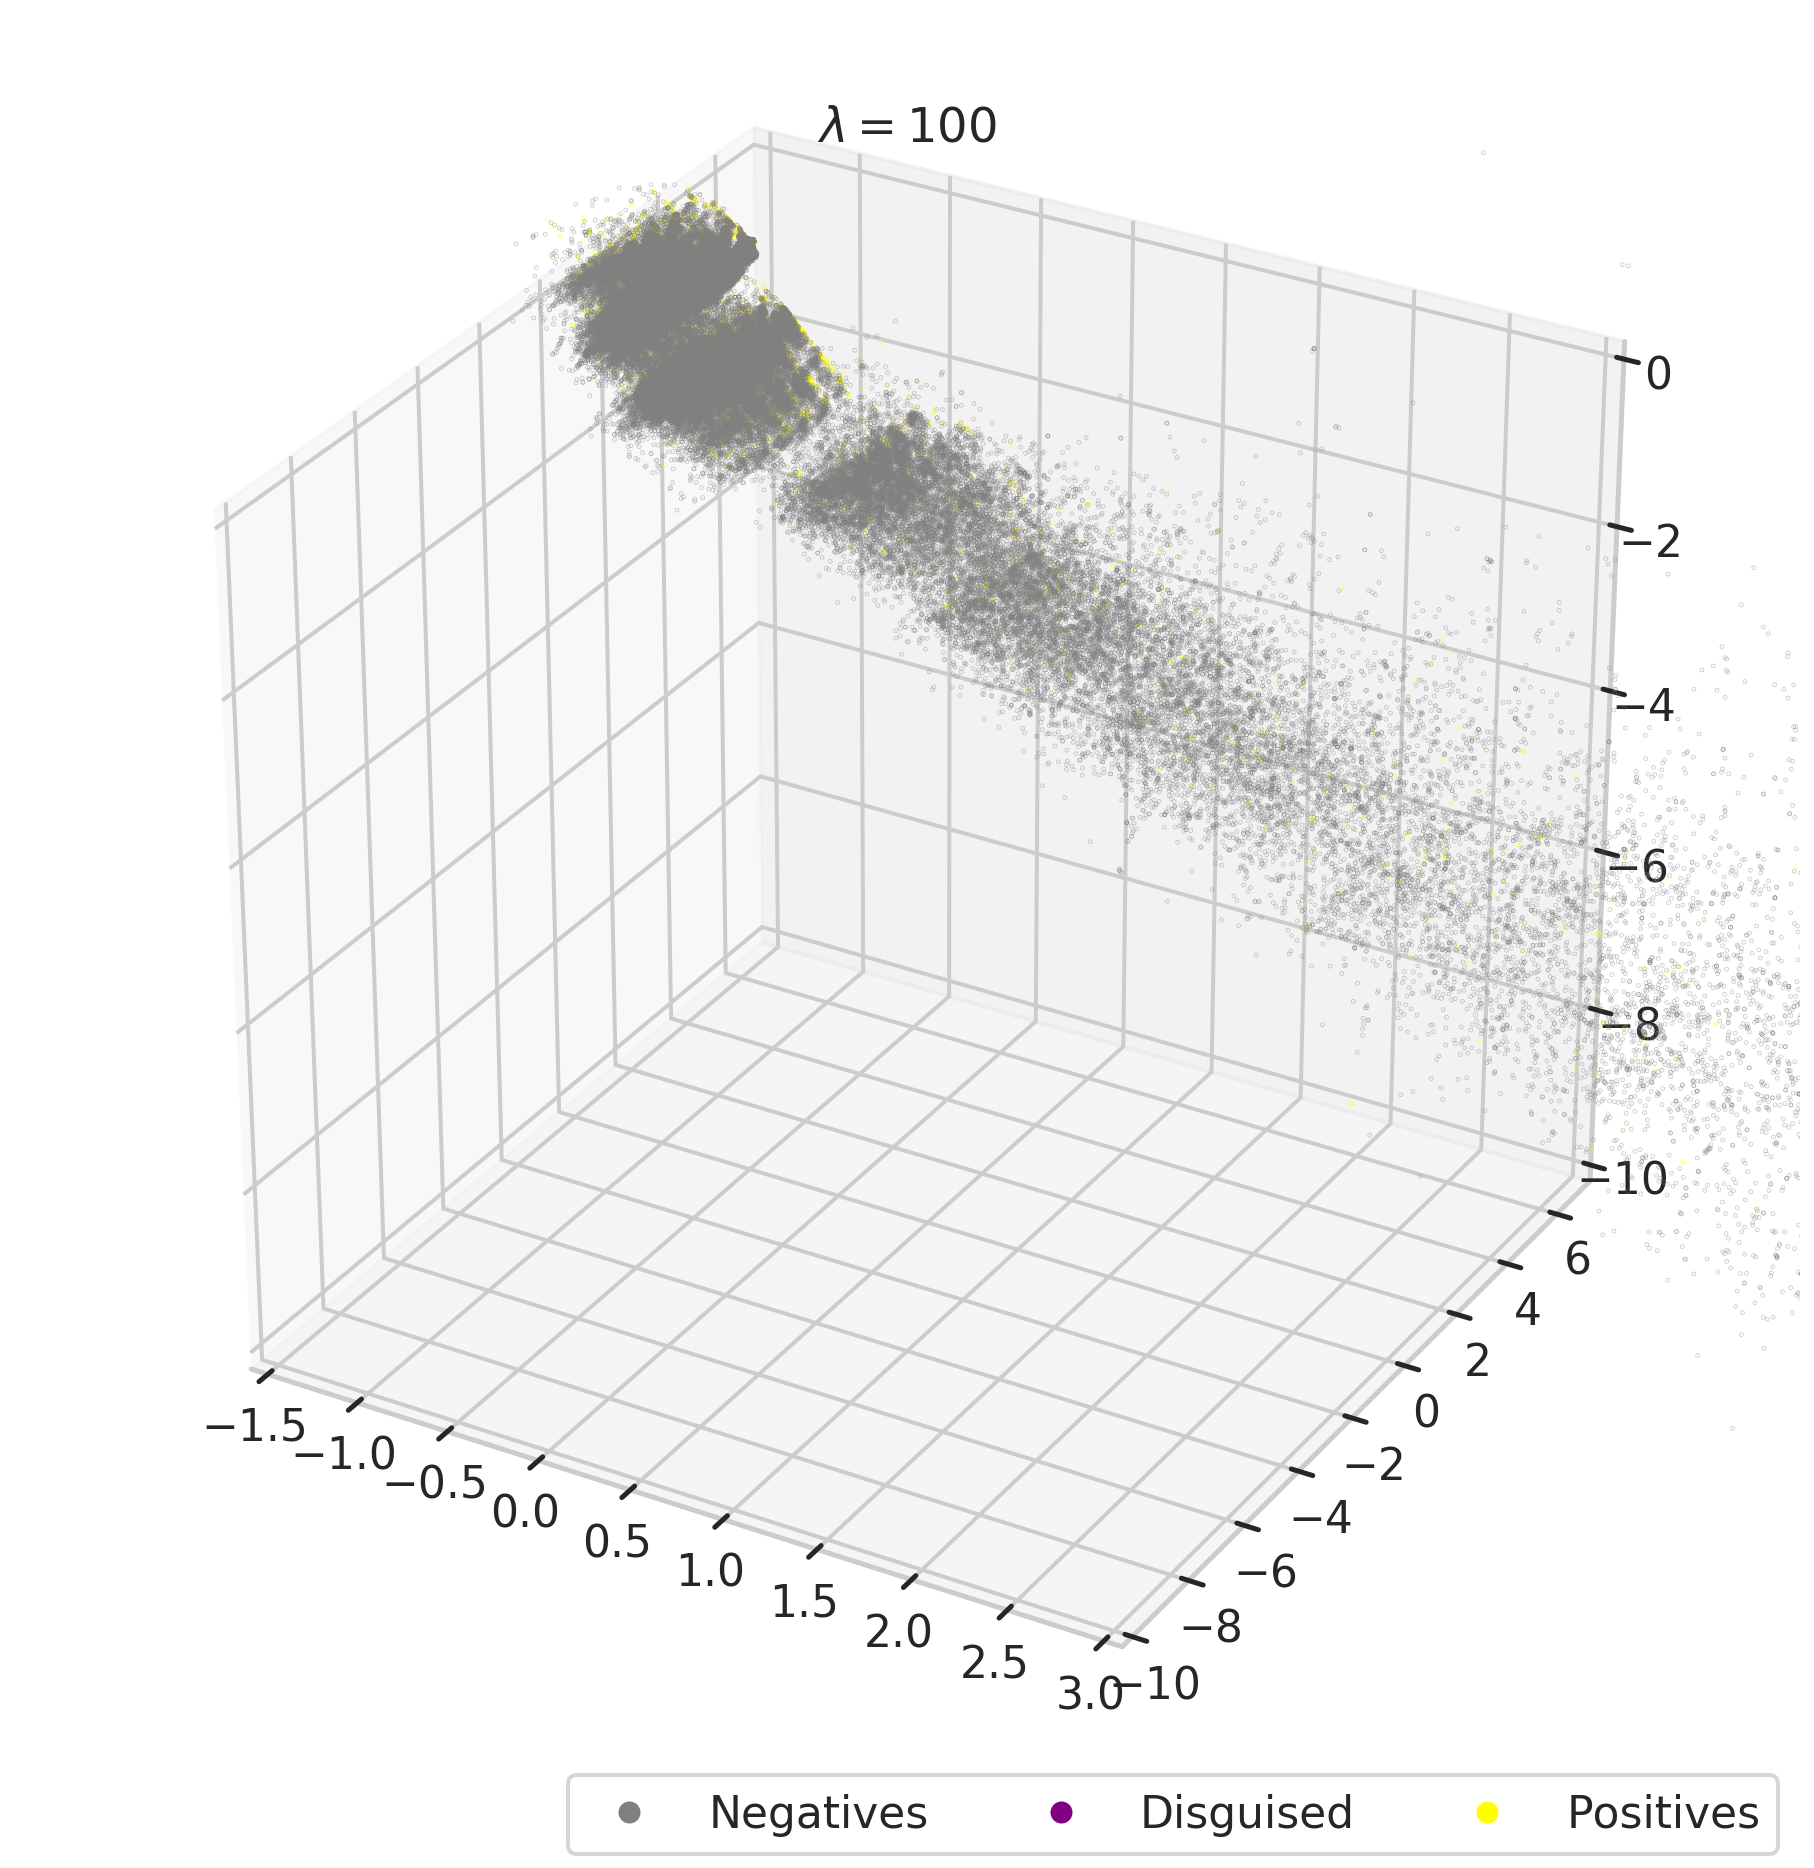

In [33]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data['neg'][:,0], pca_data['neg'][:,1], pca_data['neg'][:,2],
           color='gray', s=0.1, alpha=0.5, label='Negatives')
ax.scatter(pca_data['pos'][:,0], pca_data['pos'][:,1], pca_data['pos'][:,2],
           color='yellow', s=0.1, alpha=0.5, label='Positives')
ax.scatter(pca_data['dis'][:,0], pca_data['dis'][:,1], pca_data['dis'][:,2],
           color='purple', s=0.1, alpha=0.5, label='Disguised')
ax.set_xlim(-1.5, 3)
ax.set_ylim(-10, 7)
ax.set_zlim(-10, 0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('$\lambda={}$'.format(100))
    
neg = mlines.Line2D(
  [], [], color='gray', marker='o', linestyle='None', markersize=10, 
  label='Negatives')
dis = mlines.Line2D(
  [], [], color='yellow', marker='o', linestyle='None', markersize=10,
  label='Positives')
pos = mlines.Line2D(
  [], [], color='purple', marker='o', linestyle='None', markersize=10,
  label='Disguised')
ax.legend(handles=[neg, pos, dis], bbox_to_anchor=(1, 0), ncol=3)

In [62]:
import plotly.plotly as py
import plotly.graph_objs as go

In [81]:
n = 100000
trace1 = go.Scatter3d(
    x=pca_data['neg'][:n,0],
    y=pca_data['neg'][:n,1],
    z=pca_data['neg'][:n,2],
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color='gray',
            width=0.5
        ),
        opacity=0.1
    ),
    showlegend=True
)

trace2 = go.Scatter3d(
    x=pca_data['pos'][:n,0],
    y=pca_data['pos'][:n,1],
    z=pca_data['pos'][:n,2],
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color='yellow',
            width=0.5
        ),
        opacity=0.1
    ),
    showlegend=True
)

trace3 = go.Scatter3d(
    x=pca_data['dis'][:n,0],
    y=pca_data['dis'][:n,1],
    z=pca_data['dis'][:n,2],
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color='purple',
            width=0.5
        ),
        opacity=0.1
    ),
    showlegend=True
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title='dz-mm-cpc-embedded-imb/256-0.6-0.2-2L',
    scene=dict(
        xaxis=dict(
            range=[-2, 20]
        ),
        yaxis=dict(
            range=[-10, 10]
        ),
        zaxis=dict(
            range=[-5, 20]
        )
    ),
    showlegend=True,
)
fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='dz-mm-cpc-embedded-imb-256-0.6-0.2-2L')

The draw time for this plot will be slow for all clients.


'https://plot.ly/~zhao1701/47'